In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_value(value):
    return float(value.strip('[]'))

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Cargar los datos
data = pd.read_csv('alert_data.csv')

# Verificar si hay valores infinitos o NaN
print("¿Hay valores infinitos?", np.isinf(data).values.any())
print("¿Hay valores NaN?", data.isnull().values.any())

# Reemplazar valores infinitos por NaN (si los hay)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con valores NaN (opcional)
data.dropna(inplace=True)

# Seleccionar las características (sin la columna de tiempo)
X = data[['ear', 'gaze', 'roll', 'pitch', 'yaw', 'tired', 'asleep', 'looking_away', 'distracted']].values

# Normalizar las características (es importante para redes neuronales)
scaler = StandardScaler()

# Tratar de nuevo si es necesario
try:
    X_scaled = scaler.fit_transform(X)
except ValueError as e:
    print("Error durante la normalización:", e)



¿Hay valores infinitos? True
¿Hay valores NaN? False


In [52]:
import tensorflow as tf
from tensorflow.keras import layers

# Definir la arquitectura del Autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 4  # El número de neuronas en la capa de codificación (dimensión reducida)

# Capa de entrada
input_layer = layers.Input(shape=(input_dim,))

# Capa de codificación
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)

# Capa de decodificación
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Crear el modelo de Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Ver la arquitectura del Autoencoder
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 40        
                                                                 
 dense_5 (Dense)             (None, 9)                 45        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Entrenar el modelo
history = autoencoder.fit(X_scaled, X_scaled, 
                          epochs=100, 
                          batch_size=64, 
                          shuffle=True, 
                          validation_split=0.2)


Epoch 1/100
23/23 [==============================] - 1s 11ms/step - loss: 1.1422 - val_loss: 1.9838
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1.1230 - val_loss: 1.9784
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 1.1030 - val_loss: 1.9710
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0822 - val_loss: 1.9641
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0607 - val_loss: 1.9580
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0381 - val_loss: 1.9515
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0149 - val_loss: 1.9450
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9914 - val_loss: 1.9379
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9683 - val_loss: 1.9302
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.9462 - val_loss: 1.9230
Epoch 11

In [54]:
X_scaled.shape

(1784, 9)

In [55]:
# Obtener las reconstrucciones
reconstrucciones = autoencoder.predict(X_scaled)

# Calcular el error de reconstrucción (MSE)
mse = np.mean(np.power(X_scaled - reconstrucciones, 2), axis=1)

# Establecer un umbral para identificar anomalías
umbral = np.percentile(mse, 95)  # Elige el percentil del 95% como umbral

# Etiquetar las instancias que superan el umbral como anomalías
anomalies = mse > umbral

# Añadir las etiquetas de anomalía al dataframe original
data['anomaly'] = anomalies

# Filtrar los casos que son anomalías (posibles situaciones de riesgo)
situaciones_riesgo = data[data['anomaly'] == True]
print(situaciones_riesgo)


56/56 [==============================] - 0s 1ms/step
          timestamp       ear      gaze   roll  pitch    yaw  tired  asleep  \
114   217397.363298  0.284555  0.010096  -0.60  30.02   9.17      0       0   
606   217425.796099  0.349165  0.022146  17.05  -7.21 -31.06      0       0   
607   217425.844176  0.367789  0.019312  18.19  -9.31 -34.07      0       0   
608   217425.906731  0.349806  0.024888  15.84 -10.67 -31.50      0       0   
835   217440.101099  0.271899  0.015968  -7.04  13.78 -12.17      0       0   
...             ...       ...       ...    ...    ...    ...    ...     ...   
1761  217492.928744  0.328771  0.007506  -1.23  -5.31  21.08      1       0   
1762  217492.976345  0.332078  0.007098  -1.39  -4.44  20.68      1       0   
1763  217493.024386  0.345541  0.007504  -1.19  -3.97  20.36      1       0   
1764  217493.072368  0.335994  0.008127  -1.00  -3.85  20.17      1       0   
1765  217493.120175  0.332565  0.006771  -0.86  -3.98  19.80      1       0   

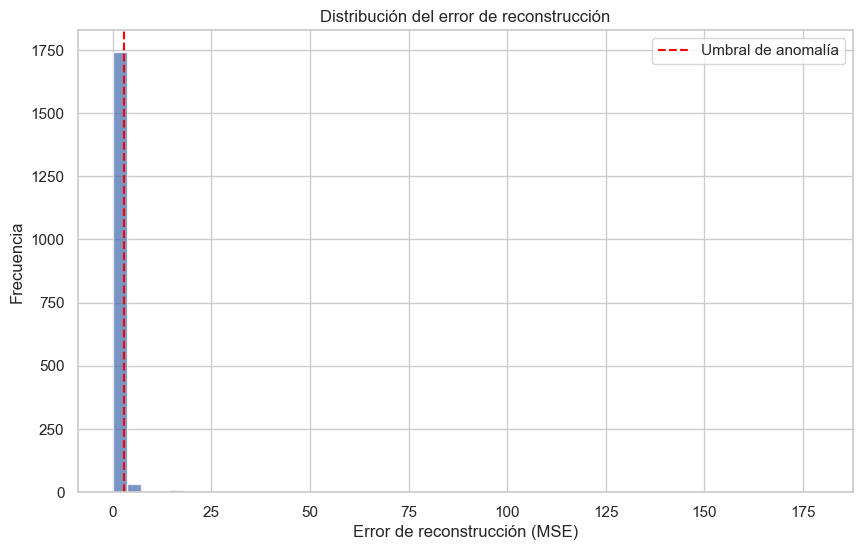

Número de situaciones de riesgo detectadas: 90
Número total de situaciones: 1784
umbral: 2.8005104731260504
error máximo: 178.73461411901908


In [56]:
import matplotlib.pyplot as plt

# Graficar el error de reconstrucción
plt.figure(figsize=(10,6))
plt.hist(mse, bins=50, alpha=0.75)
plt.axvline(umbral, color='red', linestyle='--', label='Umbral de anomalía')
plt.title('Distribución del error de reconstrucción')
plt.xlabel('Error de reconstrucción (MSE)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print('Número de situaciones de riesgo detectadas:', len(situaciones_riesgo))
print('Número total de situaciones:', len(data))
print('umbral:', umbral)
print('error máximo:', max(mse))

In [57]:
import numpy as np

# Definir el umbral de anomalía (ya identificado en tu gráfico)
umbral_anomalia = umbral

# Error máximo observado en el dataset (puedes ajustar esto de acuerdo a tu gráfico)
error_maximo = max(mse)

# Función para calcular el porcentaje de probabilidad de accidente
def calcular_probabilidad_riesgo(error_reconstruccion, umbral=umbral_anomalia, max_error=error_maximo):
    if error_reconstruccion <= umbral:
        return 0.0  # No es un riesgo si el error está por debajo del umbral
    else:
        return min(1.0, (error_reconstruccion - umbral) / (max_error - umbral)) * 100  # Escalamos a porcentaje

# Ejemplo de uso con un array de errores de reconstrucción
errores_reconstruccion = [0.2, 0.5, 1.0, 1.7, 2.5, 3.0]
probabilidades_riesgo = [calcular_probabilidad_riesgo(error) for error in errores_reconstruccion]

print(probabilidades_riesgo)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.11338877610418681]


In [58]:
# autoencoder.save('autoencoder_model.h5')

# Testing

In [59]:
import openvino as ov 
import numpy as np

model = tf.keras.models.load_model('autoencoder_model.h5')

# Convertir el modelo de TensorFlow a OpenVINO
ov_model = ov.convert_model(model)

ov.save_model(ov_model, 'autoencoder_model.xml')

RuntimeError: Check 'bin_file' failed at src\core\src\pass\serialize.cpp:1252:
Can't open bin file.


In [24]:
# data = pd.read_csv('alert_data.csv')

In [60]:
from openvino.runtime import Core
import numpy as np

# Crear una instancia del Core de OpenVINO
core = Core()

# Cargar el modelo IR
model_ir_path = 'autoencoder_model.xml'
model_ir = core.read_model(model=model_ir_path)
compiled_model = core.compile_model(model=model_ir, device_name="CPU")

In [61]:
# Preparar los datos de entrada (normalizados)
input_data = X_scaled  # Usar los datos normalizados

# Realizar la inferencia
infer_request = compiled_model.create_infer_request()
infer_request.infer(inputs={0: input_data})
output_data = infer_request.get_output_tensor().data

# Calcular el error de reconstrucción (MSE)
mse = np.mean(np.power(X_scaled - output_data, 2), axis=1)

# Establecer un umbral para identificar anomalías
umbral = np.percentile(mse, 95)  # Elige el percentil del 95% como umbral

# Etiquetar las instancias que superan el umbral como anomalías
anomalies = mse > umbral

# Añadir las etiquetas de anomalía al dataframe original
data['anomaly'] = anomalies

# Filtrar los casos que son anomalías (posibles situaciones de riesgo)
situaciones_riesgo = data[data['anomaly'] == True]
print(situaciones_riesgo)

# Calcular la probabilidad de riesgo
def calcular_probabilidad_riesgo(error_reconstruccion, umbral=umbral, max_error=max(mse)):
    if error_reconstruccion <= umbral:
        return 0.0  # No es un riesgo si el error está por debajo del umbral
    else:
        return min(1.0, (error_reconstruccion - umbral) / (max_error - umbral)) * 100  # Escalamos a porcentaje

# Calcular las probabilidades de riesgo para cada instancia
probabilidades_riesgo = [calcular_probabilidad_riesgo(error) for error in mse]
data['probabilidad_riesgo'] = probabilidades_riesgo

print(data[['anomaly', 'probabilidad_riesgo']])

          timestamp       ear      gaze   roll  pitch    yaw  tired  asleep  \
576   217424.072738  0.452200  0.021067   7.99   4.87 -30.68      0       0   
605   217425.732651  0.297277  0.021433  13.32  -5.83 -26.00      0       0   
606   217425.796099  0.349165  0.022146  17.05  -7.21 -31.06      0       0   
607   217425.844176  0.367789  0.019312  18.19  -9.31 -34.07      0       0   
608   217425.906731  0.349806  0.024888  15.84 -10.67 -31.50      0       0   
...             ...       ...       ...    ...    ...    ...    ...     ...   
1761  217492.928744  0.328771  0.007506  -1.23  -5.31  21.08      1       0   
1762  217492.976345  0.332078  0.007098  -1.39  -4.44  20.68      1       0   
1763  217493.024386  0.345541  0.007504  -1.19  -3.97  20.36      1       0   
1764  217493.072368  0.335994  0.008127  -1.00  -3.85  20.17      1       0   
1765  217493.120175  0.332565  0.006771  -0.86  -3.98  19.80      1       0   

      looking_away  distracted  anomaly  
576      

c:\Users\jesus\anaconda3\envs\datathon2024\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jesus\anaconda3\envs\datathon2024\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


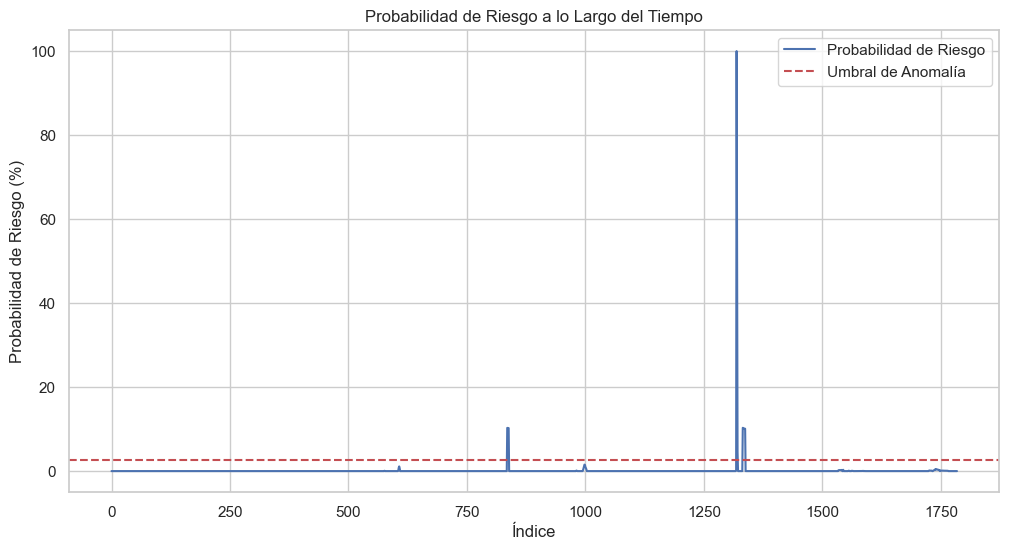

In [62]:
import seaborn as sns

# Graficar los resultados con seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x=data.index, y='probabilidad_riesgo', label='Probabilidad de Riesgo')
plt.axhline(y=umbral, color='r', linestyle='--', label='Umbral de Anomalía')
plt.xlabel('Índice')
plt.ylabel('Probabilidad de Riesgo (%)')
plt.title('Probabilidad de Riesgo a lo Largo del Tiempo')
plt.legend()
plt.savefig('probabilidad_riesgo.png', dpi=500)
plt.show()

In [63]:
from openai import OpenAI

# Configurar el cliente de OpenAI
client = OpenAI(
    api_key="-",
    base_url="https://fridaplatform.com/v1"
)

# Función para generar recomendaciones basadas en la probabilidad de riesgo y parámetros
def generar_recomendaciones(prob_riesgo, ear, gaze, roll, pitch, yaw, tired, asleep, looking_away, distracted):
    # Crear el mensaje para enviar a la API de FRIDA SOFTTEKK
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"Based on the following parameters, provide recommendations:\n"
                                    f"Probability of Risk: {prob_riesgo}%\n"
                                    f"EAR: {ear}\n"
                                    f"Gaze: {gaze}\n"
                                    f"Roll: {roll}\n"
                                    f"Pitch: {pitch}\n"
                                    f"Yaw: {yaw}\n"
                                    f"Tired: {tired}\n"
                                    f"Asleep: {asleep}\n"
                                    f"Looking Away: {looking_away}\n"
                                    f"Distracted: {distracted}"}
    ]

    # Llamar a la API de FRIDA SOFTTEKK para obtener las recomendaciones
    response = client.chat.completions.create(
        model="tgi",
        messages=messages,
        stream=False
    )

    # Extraer las recomendaciones de la respuesta
    recomendaciones = response.choices[0].message.content
    return recomendaciones

# Ejemplo de uso de la función
prob_riesgo = 75.0
ear = 0.25
gaze = 0.5
roll = 10.0
pitch = 5.0
yaw = 15.0
tired = 1
asleep = 0
looking_away = 1
distracted = 1

recomendaciones = generar_recomendaciones(prob_riesgo, ear, gaze, roll, pitch, yaw, tired, asleep, looking_away, distracted)
print(recomendaciones)

Based on the provided parameters, here are some observations and recommendations:

1. **High Risk Level**: The Probability of Risk is 75.0%, indicating a significant concern. This suggests that the individual is likely to be at risk of an accident or incident.

2. **Driver State**: Given that both "Tired" and "Looking Away" are 1, and "Distracted" is also 1, it implies that the driver is not fully attentive and focused on the road.
